# OCR

In [1]:
import pandas as pd
from PIL import Image
import pickle
import io
from pydantic import BaseModel, Field
import pickle
from langchain.output_parsers import PydanticOutputParser
from utils import imageObjCreation, readImgOCR, LLMModelCall, instructionsFormat
from ticket import Ticket

We will extract general information from a ticket receipt using OCR techniques. First let's see one sample image of the dataset that will be used

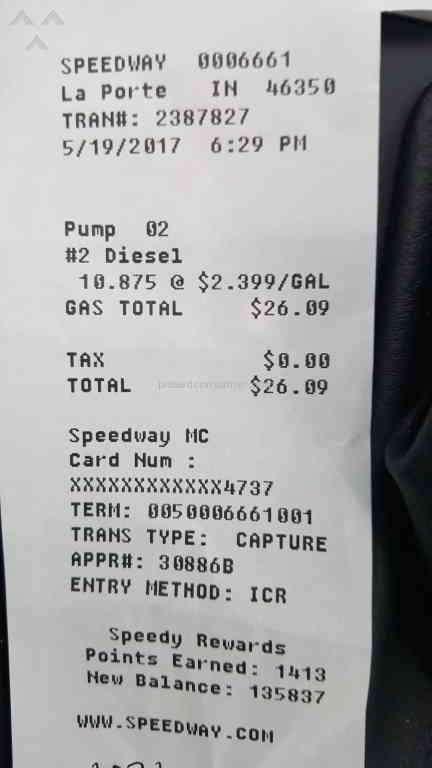

In [2]:
# Load the parquet file into a pandas dataframe
df = pd.read_parquet('/teamspace/studios/this_studio/ProjectGenAI/data/receipts/train-00000-of-00001-cb0a33d1d06a80b4.parquet')

# Display the first image
image_dict = df.iloc[0]['image']
image_bytes = image_dict['bytes']

# Open the image using PIL and display it
image = Image.open(io.BytesIO(image_bytes))
image.show()

Now let's decode and store both the images and its bytes.

In [3]:
images_list = []
images_bytes_list = []
for image in df["image"]:
    images_bytes_list.append(image["bytes"])
    images_list.append(imageObjCreation(image["bytes"]))

In [4]:
# Read the images using OCR and save them into a pickle file for later use
'''
textOcr_list = []

for image in range(len(images_list)):
    textOcr_list.append(readImgOCR(images_bytes_list[image], images_list[image]))

with open('/teamspace/studios/this_studio/ProjectGenAI/data/receipts/l_textOcr.pkl', 'wb') as file:
    pickle.dump(textOcr_list, file)
'''

'\nl_textOcr = []\n\nfor image_i in range(len(l_images)):\n    l_textOcr.append(readImgOCR(l_images_bytes[image_i], l_images[image_i]))\n'

In [4]:
# Load the content of textOCR_list from the pickle file
with open('/teamspace/studios/this_studio/ProjectGenAI/data/receipts/l_textOcr.pkl', 'rb') as file:
    textOcr_list = pickle.load(file)

# Print the first 5 tickets text extracted
textOcr_list[:6]

['SPEEDUAY 0006661 La Porte IN 76350 TRANI : 2387827 5/19/2017 6 : 29 PI 02 #2 Diesel 10.875 @ $2.399/GaL Gas ToTaL $26 09 Tax $0.00 ToTaL $26 09 Speedvay MC Card Num XXXXXXXXXXXX4737 TERM: 0050006661001 TRANS  TYPE: CAPTURE APPR#: 3 0886B EnTRY Method: ICR Speedy Points New 1413 Dalance: 135837 vnw coh Punp Rewards Earned SPEEDVAY',
 "MASTORIS DINER 144 ROUTE 130 BORDENTOWN , NJ #(609)-298-4650 276 ANGELA POWELL 2/3 1885 GST 2 O4Nov ' 17 9;32AM HAM&EGG BURRITO 9,99 1 SS PANCAKES 5.99 ADD STRWBER 3.00 INSIDE #SPEC PREP* 2 HOT TEA 4,98 Subtota] 23,96 Tax 1.65 10;00 Payment Due 25 61 EAGLES 7-1 COWBOYS 4-3 REDSKINS 3-4 GIANTS 1-6 GO EAGLES !",
 "Max 5 Cafe 2200 Fifth Ave Seattle  WA   98121 206-441-9785 9999998  Trainee Tbl 31/1 Chk   1441 Gst 2 Jul19' 14 12:36PM BenSPECIAL 12,50 YELP Open $ Disc 2.05 - Wait 10 % Open % Disc 1,05- Caprese 10.00 Add Chicken 1,00 YELP Open $ Disc 1,80 - Pineapple Bellin 7,00 YELP Open $ Disc 1,15- Subtota] 24,45 Tax 2,32 01:O2PM Total 26 77",
 'fargA GRAn 

In [5]:
# Define the parser that will be used by the LLM
parser = PydanticOutputParser(pydantic_object = Ticket)
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"description": "TicketDatamodel", "properties": {"name": {"default": "NA", "description": "Name of the establishment where the purchase was made", "title": "Name", "type": "string"}, "address": {"default": "NA", "description": "Address of the establishment", "title": "Address", "type": "string"}, "date": {"default": "NA", "description": "Date of the ticket", "title": "Date", "type": "string"}, "total": {"default": "NA", "description": "Total money amount of the ticket", "title": "Total", "type": "string"}, "category": {"default": "NA", "descr

In [6]:
# Finally, use the LLM to get the text extracted from the OCR, process it in the Ticket format, and output 
# a JSON object of it. The parser then is used to convert it to a string so that it can be stored later into
# a vectorial database.
'''
ticket_data_list = []
generated_text_list = []

for textOcr in textOcr_list:
    system_instructions, prompt = instructionsFormat(parser, textOcr)
    generated_text = LLMModelCall(system_instructions, prompt)
    generated_text_list.append(generated_text)
    # Pass output to string (?) to be rightly stored in the chroma database
    ticket_data = parser.parse(generated_text)
    ticket_data_list.append(ticket_data)
    print(ticket_data)

# Save the content of ticketdata_list using pickle
with open('/teamspace/studios/this_studio/ProjectGenAI/data/receipts/l_ticket_data.pkl', 'wb') as file:
    pickle.dump(ticket_data_list, file)
'''

with open('/teamspace/studios/this_studio/ProjectGenAI/data/receipts/l_ticket_data.pkl', 'rb') as file:
    ticket_data_list = pickle.load(file)

# print(type(ticket_data_list[0]))

### Store tickets into chroma database

In [7]:
import json

# Convert Ticket objects to dictionaries
ticket_dicts = [ticket.dict() for ticket in ticket_data_list]

# Serialize dictionaries to JSON strings
ticket_jsons = [json.dumps(ticket_dict) for ticket_dict in ticket_dicts]

In [11]:
import chromadb

# Initialize ChromaDB client
client = chromadb.Client()  # Replace with actual initialization if needed
collection = client.get_or_create_collection("ticket_collection")
ids = [str(i) for i in range(len(ticket_jsons))]
collection.add(ids=ids, documents=ticket_jsons)

/teamspace/studios/this_studio/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz:   6%|▌         | 4.50M/79.3M [00:00<00:01, 47.2MiB/s]

/teamspace/studios/this_studio/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:01<00:00, 72.3MiB/s]
